In [1]:
import os
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import albumentations as A
import torch.utils.data as data
import matplotlib.pyplot as plt
import torchvision.transforms as tt
from PIL import Image
from torchvision import transforms
from torch.utils.data import DataLoader

In [2]:
# (DoubleConv, Down, Up, OutConv, UNet)をここに含める

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True))
    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels))
    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then double conv"""
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels//2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)
    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX//2, diffX-diffX//2,
                        diffY//2, diffY-diffY//2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1),
            nn.Sigmoid())
    def forward(self, x):
        return self.conv(x)

In [3]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024//factor)
        self.up1 = Up(1024, 512//factor, bilinear)
        self.up2 = Up(512, 256//factor, bilinear)
        self.up3 = Up(256, 128//factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [4]:
# デバイスの設定（CUDAが利用可能であればGPUを使う）
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# モデルのインスタンスを作成
model = UNet(n_channels=3, n_classes=1).to(device)

# 学習済みのモデルの重みをロード
model.load_state_dict(torch.load('./brain-mri-unet.pth', map_location=device))

# モデルを評価モードに設定
model.eval()

# ダミー入力データを作成してモデルに通し、出力形状を確認
dummy_input = torch.randn(1, 3, 128, 128).to(device)
with torch.no_grad():
    output = model(dummy_input)
print(f'Input shape: {dummy_input.shape}')
print(f'Output shape: {output.shape}')

Input shape: torch.Size([1, 3, 128, 128])
Output shape: torch.Size([1, 1, 128, 128])


In [5]:
person_id = "TCGA_CS_5395_19981004"

base_path = os.getcwd()
ROOT_PATH = os.path.join(base_path, "bigdata", "kaggle_3m", person_id)
mask_path = os.path.join(ROOT_PATH, f"{person_id}_13_mask.tif")
image_path = mask_path.replace("_mask", "")

In [6]:
print(image_path)

/home/eiji/practice/unet/bigdata/kaggle_3m/TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_13.tif


In [7]:
class BrainDataset(data.Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image = cv2.imread(self.df.iloc[idx, 0])
        image = np.array(image)/255.
        mask = cv2.imread(self.df.iloc[idx, 1], 0)
        mask = np.array(mask)/255.

        if self.transform is not None:
            aug = self.transform(image=image, mask=mask)
            image = aug['image']
            mask = aug['mask']

        image = image.transpose((2,0,1))
        image = torch.from_numpy(image).type(torch.float32)
        image = tt.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(image)
        mask = np.expand_dims(mask, axis=-1).transpose((2,0,1))
        mask = torch.from_numpy(mask).type(torch.float32)

        return image, mask

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


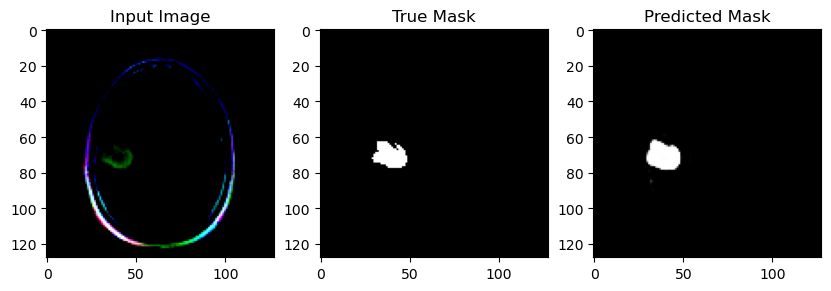

In [8]:

test_transform = A.Compose([
    A.Resize(width=128, height=128, p=1.0)
])

# 新しい画像ファイル名を指定する
new_image_path = image_path
new_mask_path = mask_path

# BrainDataset インスタンスを作成する
new_data = {'image_path': [new_image_path], 'mask_path': [new_mask_path]}
new_df = pd.DataFrame(new_data)
new_ds = BrainDataset(new_df, transform=test_transform)  # ここで適切な変換を適用

# データローダーを作成する
new_dl = DataLoader(new_ds, batch_size=1, shuffle=False)

# モデルの出力を取得して表示・保存する関数
def predict_and_save(model, dataloader, device):
    model.eval()
    with torch.no_grad():
        for image, mask in dataloader:
            image = image.to(device)
            pred_mask = model(image)

            # 出力を表示する
            plt.figure(figsize=(10, 5))

            plt.subplot(1, 3, 1)
            plt.imshow(image[0].cpu().numpy().transpose(1, 2, 0))
            plt.title('Input Image')

            plt.subplot(1, 3, 2)
            plt.imshow(mask[0].cpu().numpy().transpose(1, 2, 0).squeeze(), cmap='gray')
            plt.title('True Mask')

            plt.subplot(1, 3, 3)
            plt.imshow(pred_mask[0].cpu().numpy().transpose(1, 2, 0).squeeze(), cmap='gray')
            plt.title('Predicted Mask')

            plt.show()

            # 出力を保存する
            pred_mask_np = pred_mask[0].cpu().numpy().transpose(1, 2, 0).squeeze()
            pred_mask_img = Image.fromarray((pred_mask_np * 255).astype(np.uint8))
            pred_mask_img.save('predicted_mask.png')

# モデルに新しい画像を入力して結果を表示・保存する
predict_and_save(model, new_dl, device)
